Задание по классификации - добавляется еще один классификатор: Multi-layer Perceptron
https://scikit-learn.org/stable/modules/neural_networks_supervised.html


## Подготовка векторного представления lsi lda


In [4]:
import warnings
import numpy as np
import re
import string
import nltk
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from tqdm.notebook import tqdm
from gensim import corpora, models
from nltk import pos_tag
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from catboost import CatBoostClassifier, Pool
warnings.filterwarnings("ignore")

/Users/igorkopylov/PycharmProjects/liner_model/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
from sklearn.datasets import fetch_20newsgroups
number_of_topic = 3
newsgroups_train = fetch_20newsgroups(subset='train')
indices = np.where((newsgroups_train.target >= 0) & (newsgroups_train.target <= number_of_topic))[0]
texts = [newsgroups_train.data[i] for i in indices]
target = np.array([newsgroups_train.target[i] for i in indices])
print(f"Всего элементов: {target.shape[0]}")
for i in range(number_of_topic):
    count = np.count_nonzero(target == i)
    print(f"ко-во элементов из класса {i}: {count}")

Всего элементов: 2245
ко-во элементов из класса 0: 480
ко-во элементов из класса 1: 584
ко-во элементов из класса 2: 591


In [6]:
def spacy_lemmatize_tokens(tokens):
    
    nlp = spacy.load("en_core_web_sm")

    # Лемматизация слова "running"
    doc = nlp(' '.join(tokens))
    lemmas = [token.lemma_ for token in doc]
    return lemmas

def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return lemmatized_tokens


def preprocess_text(text): 
    # Удаление пунктуации
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    lemmatized_tokens = lemmatize_tokens(tokens)  #spacy_lemmatize_tokens(tokens)
    return lemmatized_tokens

In [7]:
tokenized_corpus = [preprocess_text(i) for i in texts]
tokenized_corpus[0][:5]

['From', 'jgreenamber', 'Joe', 'Green', 'Subject']

### LDA

In [8]:
def lda_repo(tokenized_corpus, num_topics=15):
    # Создание словаря
    dictionary = Dictionary(tokenized_corpus)
    
    # Преобразование текстов в мешок слов
    bow_corpus = [dictionary.doc2bow(text) for text in tokenized_corpus]
    
    # Обучение модели LDA
    lda_model = LdaModel(
        corpus=bow_corpus,  # Мешок слов
        id2word=dictionary,  # Словарь
        num_topics=num_topics,  # Количество тем
        passes=10,  # Количество итераций по корпусу
        iterations=100,  # Количество итераций для оценки параметров
        random_state=42  # Зафиксированный случайный seed для воспроизводимости результатов
    )
    return lda_model, bow_corpus

In [11]:
best_param = 10
lda_model, bow_corpus = lda_repo(tokenized_corpus, best_param)

In [12]:
# получаем тематические векторы
lda_vec = []
for i in tqdm(range(len(target))):
    doc_topics = lda_model.get_document_topics(bow_corpus[i])
    doc_vec = np.zeros(best_param)
    for topic, prob in doc_topics:
        #top_numb = int(re.sub(r'[a-zA-Z]', '', topic))
        doc_vec[topic] = prob
    lda_vec.append(doc_vec)

  0%|          | 0/2245 [00:00<?, ?it/s]

In [13]:
print("ready")

ready


### LSI

In [14]:
def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()

    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return lemmatized_tokens


def preprocess_text(text): 
    # Удаление пунктуации
    text = re.sub(r'[^\w\s]', '', text)
    
    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    
    tokens = [token for token in tokens if token not in stop_words]

    lemmatized_tokens = lemmatize_tokens(tokens)
    
    return " ".join(lemmatized_tokens)

In [15]:
corpus = [preprocess_text(i) for i in texts]
corpus[0][:60]

'From jgreenamber Joe Green Subject Re Weitek P9000 Organizat'

In [17]:
tfidf_vectorizer = TfidfVectorizer()

tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
mini_size = 100 #  1680 best size
lsa_model = TruncatedSVD(n_components=mini_size)
lsi_vectors = lsa_model.fit_transform(tfidf_matrix)

In [18]:
print('ready')

ready


### params

hidden_layer_sizesarray-like of shape(n_layers - 2,), default=(100,)
The ith element represents the number of neurons in the ith hidden layer.

activation{‘identity’, ‘logistic’, ‘tanh’, ‘relu’}, default=’relu’
Activation function for the hidden layer.

‘identity’, no-op activation, useful to implement linear bottleneck, returns f(x) = x
‘logistic’, the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).
‘tanh’, the hyperbolic tan function, returns f(x) = tanh(x).
‘relu’, the rectified linear unit function, returns f(x) = max(0, x)
solver{‘lbfgs’, ‘sgd’, ‘adam’}, default=’adam’
The solver for weight optimization.

‘lbfgs’ is an optimizer in the family of quasi-Newton methods.
‘sgd’ refers to stochastic gradient descent.
‘adam’ refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba
Note: The default solver ‘adam’ works pretty well on relatively large datasets (with thousands of training samples or more) in terms of both training time and validation score. For small datasets, however, ‘lbfgs’ can converge faster and perform better.

alphafloat, default=0.0001
Strength of the L2 regularization term. The L2 regularization term is divided by the sample size when added to the loss.

batch_sizeint, default=’auto’
Size of minibatches for stochastic optimizers. If the solver is ‘lbfgs’, the classifier will not use minibatch. When set to “auto”, batch_size=min(200, n_samples).

learning_rate{‘constant’, ‘invscaling’, ‘adaptive’}, default=’constant’
Learning rate schedule for weight updates.

‘constant’ is a constant learning rate given by ‘learning_rate_init’.
‘invscaling’ gradually decreases the learning rate at each time step ‘t’ using an inverse scaling exponent of ‘power_t’. effective_learning_rate = learning_rate_init / pow(t, power_t)
‘adaptive’ keeps the learning rate constant to ‘learning_rate_init’ as long as training loss keeps decreasing. Each time two consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if ‘early_stopping’ is on, the current learning rate is divided by 5.
Only used when solver='sgd'.

learning_rate_initfloat, default=0.001
The initial learning rate used. It controls the step-size in updating the weights. Only used when solver=’sgd’ or ‘adam’.

power_tfloat, default=0.5
The exponent for inverse scaling learning rate. It is used in updating effective learning rate when the learning_rate is set to ‘invscaling’. Only used when solver=’sgd’.

max_iterint, default=200
Maximum number of iterations. The solver iterates until convergence (determined by ‘tol’) or this number of iterations. For stochastic solvers (‘sgd’, ‘adam’), note that this determines the number of epochs (how many times each data point will be used), not the number of gradient steps.

shufflebool, default=True
Whether to shuffle samples in each iteration. Only used when solver=’sgd’ or ‘adam’.

random_stateint, RandomState instance, default=None
Determines random number generation for weights and bias initialization, train-test split if early stopping is used, and batch sampling when solver=’sgd’ or ‘adam’. Pass an int for reproducible results across multiple function calls. See Glossary.

tolfloat, default=1e-4
Tolerance for the optimization. When the loss or score is not improving by at least tol for n_iter_no_change consecutive iterations, unless learning_rate is set to ‘adaptive’, convergence is considered to be reached and training stops.

verbosebool, default=False
Whether to print progress messages to stdout.

warm_startbool, default=False
When set to True, reuse the solution of the previous call to fit as initialization, otherwise, just erase the previous solution. See the Glossary.

momentumfloat, default=0.9
Momentum for gradient descent update. Should be between 0 and 1. Only used when solver=’sgd’.

nesterovs_momentumbool, default=True
Whether to use Nesterov’s momentum. Only used when solver=’sgd’ and momentum > 0.

early_stoppingbool, default=False
Whether to use early stopping to terminate training when validation score is not improving. If set to true, it will automatically set aside 10% of training data as validation and terminate training when validation score is not improving by at least tol for n_iter_no_change consecutive epochs. The split is stratified, except in a multilabel setting. If early stopping is False, then the training stops when the training loss does not improve by more than tol for n_iter_no_change consecutive passes over the training set. Only effective when solver=’sgd’ or ‘adam’.

validation_fractionfloat, default=0.1
The proportion of training data to set aside as validation set for early stopping. Must be between 0 and 1. Only used if early_stopping is True.

beta_1float, default=0.9
Exponential decay rate for estimates of first moment vector in adam, should be in [0, 1). Only used when solver=’adam’.

beta_2float, default=0.999
Exponential decay rate for estimates of second moment vector in adam, should be in [0, 1). Only used when solver=’adam’.

epsilonfloat, default=1e-8
Value for numerical stability in adam. Only used when solver=’adam’.

n_iter_no_changeint, default=10
Maximum number of epochs to not meet tol improvement. Only effective when solver=’sgd’ or ‘adam’.

New in version 0.20.
max_funint, default=15000
Only used when solver=’lbfgs’. Maximum number of loss function calls. The solver iterates until convergence (determined by ‘tol’), number of iterations reaches max_iter, or this number of loss function calls. Note that number of loss function calls will be greater than or equal to the number of iterations for the MLPClassifier.

New in version 0.22.

## Обучение

### LSI

In [19]:
print(f"размер датасета: {(len(lsi_vectors), len(lsi_vectors[0]))}")
print(f"количество классов: {len(set(target))}")

размер датасета: (2245, 100)
количество классов: 4


In [20]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(lsi_vectors, target, test_size=0.2, random_state=42)
# input_size = (len(lsi_vectors[0]))
# out_size = len(set(target))
mlp = MLPClassifier(hidden_layer_sizes=(100, 50),  max_iter=1, warm_start=True, random_state=42)
# max_iter - параметр для sgb (к-во итераций по датасету для одного прохода)


In [21]:
from tqdm import tqdm
import matplotlib.pyplot as plt

In [22]:
train_errors = []
test_errors = []
for i in tqdm(range(1000), desc="Training", position=0, leave=True):
    mlp.partial_fit(X_train, y_train, classes=np.unique(y_train))
    
    train_errors.append(mlp.score(X_train, y_train))
    test_errors.append(mlp.score(X_test, y_test))

Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.60it/s]


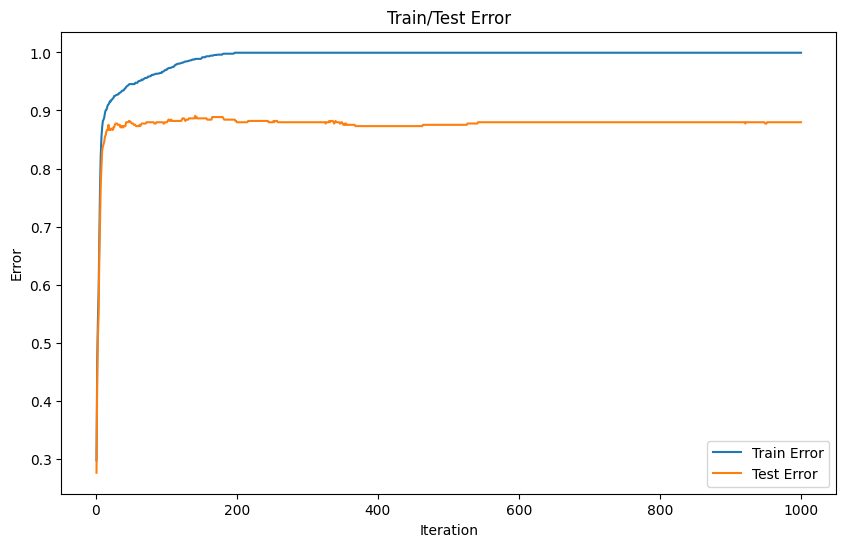

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_errors) + 1), train_errors, label='Train Error')
plt.plot(range(1, len(test_errors) + 1), test_errors, label='Test Error')
plt.title('Train/Test Error')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend()
plt.show()

In [25]:
from sklearn.model_selection import GridSearchCV

mlp = MLPClassifier(random_state=42)

param_grid = {
    'hidden_layer_sizes': [(50, 30), (100, 50), (50, 50)],
    'activation': ['relu', 'tanh', 'logistic'],
    'max_iter': [100, 200, 300]
}

grid_search = GridSearchCV(mlp, param_grid, cv=3)

grid_search.fit(X_train, y_train)

print("Лучшие гиперпараметры:")
print(grid_search.best_params_)

y_pred = grid_search.predict(X_test)
print("\nОтчет о классификации:")
print(classification_report(y_test, y_pred))

Лучшие гиперпараметры:
{'activation': 'relu', 'hidden_layer_sizes': (100, 50), 'max_iter': 100}

Отчет о классификации:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        98
           1       0.89      0.83      0.86       117
           2       0.84      0.84      0.84       129
           3       0.79      0.86      0.82       105

    accuracy                           0.88       449
   macro avg       0.88      0.88      0.88       449
weighted avg       0.88      0.88      0.88       449



# Lda


In [26]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(lsi_vectors, target, test_size=0.2, random_state=42)
mlp = MLPClassifier(hidden_layer_sizes=(100, 50),  max_iter=1, warm_start=True, random_state=42)
train_errors = []
test_errors = []
for i in tqdm(range(1000), desc="Training", position=0, leave=True):
    mlp.partial_fit(X_train, y_train, classes=np.unique(y_train))
    
    train_errors.append(mlp.score(X_train, y_train))
    test_errors.append(mlp.score(X_test, y_test))

Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 54.10it/s]


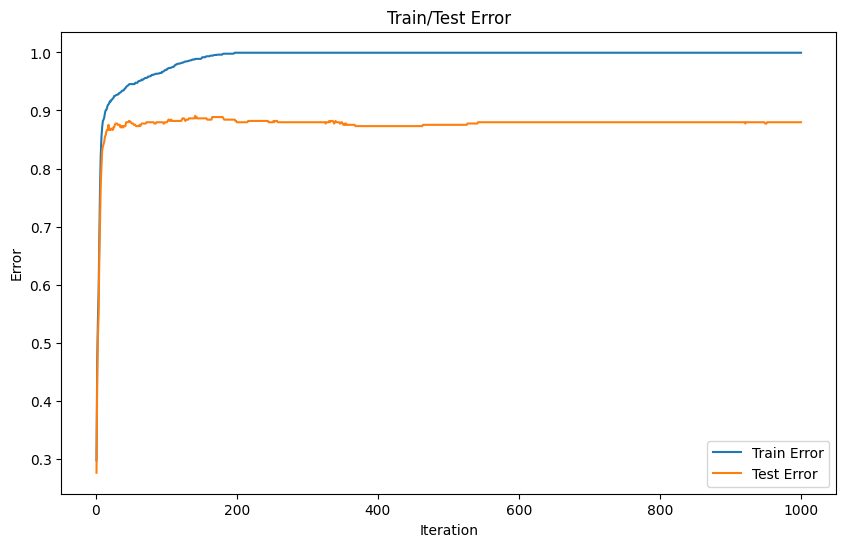

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_errors) + 1), train_errors, label='Train Error')
plt.plot(range(1, len(test_errors) + 1), test_errors, label='Test Error')
plt.title('Train/Test Error')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend()
plt.show()